# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.feature_selection import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from imblearn.datasets import make_imbalance
from category_encoders.target_encoder import TargetEncoder
import statsmodels.api as sm
import datetime as dt
import category_encoders as ce
import eli5
from eli5.sklearn import PermutationImportance
import random

In [2]:
start=dt.datetime.now()
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.000052


# Functions

In [3]:
def upsample_classes(data, target):
    
    lst = list(data[target].unique())
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    regroup = pd.concat(classes)
    maj_class = regroup[regroup[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    minority_classes = pd.concat(new_classes)
    upsample = pd.concat([regroup[regroup[target]==class_lab],minority_classes])

    return upsample

In [4]:
def target_encoding(data, column, target):
    
    grouped = data[[column,target]].groupby(column,as_index=False).mean()
    empty_dict = {}
    for i in range(len(grouped)):
        empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
    data[column]=data[column].map(lambda x: empty_dict[x])
    
    return data

In [5]:
def classification_model(X,y,method,target,test_balance = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=14)
    
    train = pd.concat([X_train,y_train],axis=1)
    
    train_balanced = upsample_classes(train, target)
    
    X_train = train_balanced.drop(target, axis=1)
    y_train = train_balanced[target]
    
    if test_balance == True:
        test = pd.concat([X_test,y_test],axis=1)
        test_balanced = upsample_classes(test, len(y.unique()), target)
        X_test = test_balanced.drop(target, axis=1)
        y_test = test_balanced[target]
    
    method.fit(X_train,y_train)
    p = method.predict(X_test)
    
    print('accuracy score')
    print(f1_score(y_test, p ,average='micro'))
    print('-'*20)
    
    plt.figure(figsize=(15,8))
    sns.heatmap(confusion_matrix(y_test,p))
    plt.tight_layout()
    plt.show()

# First pipeline

In [6]:
df = pd.read_csv('df_pipe.csv')

In [7]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [8]:
df.drop('price',axis=1,inplace=True)

In [9]:
column_trans_hot = make_column_transformer(
    (OneHotEncoder(), ['color', 'cut','clarity']),
    remainder='passthrough')

column_trans_lab = make_column_transformer(
    (LabelEncoder(), ['color', 'cut','clarity']),
    remainder='passthrough')

In [10]:
ma = MaxAbsScaler()
labs = LabelEncoder()
svm = SVC()

In [11]:
pipe_basic_hot = make_pipeline(column_trans_hot, ma, svm)
pipe_basic_lab = make_pipeline(column_trans_lab, ma, svm)

In [12]:
print(df.shape)
df.head()

(53250, 9)


,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0


In [13]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [14]:
df=df.sample(n=5000)

In [15]:
df.shape

(5000, 8)

In [17]:
X = df.drop(['price_bin'],axis=1)
y = df.price_bin

In [18]:
balance_df = upsample_classes(pd.concat([X,y],axis=1),'price_bin')
Xb = balance_df.drop(['price_bin'],axis=1)
yb = balance_df.price_bin

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xb,yb)

In [20]:
upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),'price_bin')

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       856
         1.0       0.92      0.92      0.92       944
         2.0       0.85      0.89      0.87       853
         3.0       0.97      0.88      0.92      1018

    accuracy                           0.92      3671
   macro avg       0.92      0.92      0.92      3671
weighted avg       0.92      0.92      0.92      3671



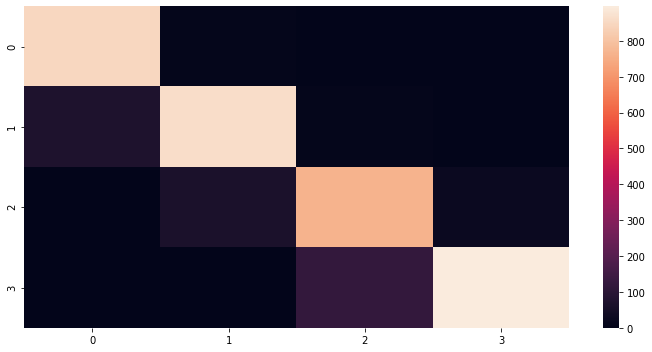

In [21]:
pipe_basic_hot.fit(X_train,y_train)
p = pipe_basic_hot.predict(X_test)
print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

# Gridsearch

In [79]:
start=dt.datetime.now()

parameters = {'C': [0.1, 1, 10, 100, 1000],  'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  

CV = GridSearchCV(svm, parameters,refit = True, verbose = 0)
CV.fit(X_train.select_dtypes(exclude='O'), y_train)   

print('Best score and parameter combination')

print(CV.best_score_)    
print(CV.best_params_) 

print('Elapsed time: ',str(dt.datetime.now()-start))

Best score and parameter combination
0.9733038318082545
{'C': 1000, 'gamma': 1}
Elapsed time:  0:06:09.411951


In [22]:
ma = MaxAbsScaler()
labs = LabelEncoder()
svm = SVC(C=1000,gamma=1)

In [23]:
pipe_basic_hot = make_pipeline(column_trans_hot, ma, svm)
pipe_basic_lab = make_pipeline(column_trans_lab, ma, svm)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       889
         1.0       0.97      0.96      0.96       944
         2.0       0.99      0.97      0.98       904
         3.0       1.00      0.99      0.99       934

    accuracy                           0.98      3671
   macro avg       0.98      0.98      0.98      3671
weighted avg       0.98      0.98      0.98      3671



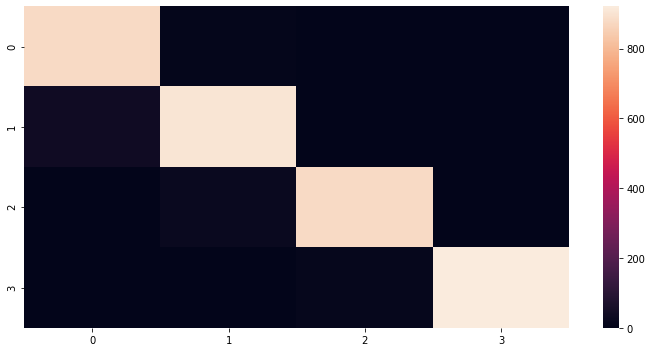

In [24]:
pipe_basic_hot.fit(X_train,y_train)
p = pipe_basic_hot.predict(X_test)
print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

# More gridsearch

In [27]:
start = dt.datetime.now()

pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('svm', SVC(random_state=14))])

grid = [{'svm__kernel': ['poly', 'sigmoid'],
         'svm__C': [0.01, 1, 100],
         'svm__degree': [2,3,4,5],
         'svm__gamma': [0.001, 0.01]}]

gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

gridsearch.fit(X_train, y_train)

print('Elapsed time: ',str(dt.datetime.now()-start))

ValueError: could not convert string to float: 'Ideal'

# custom pipelines

In [ ]:
# add correlation


In [ ]:
def fake_pipe_good(data, scaler, dimension, cat_transform, model, target):
    
    if cat_transform == 't':
        for col in data.drop(target,axis=1).select_dtypes(include = 'O').columns:
            t = TargetEncoder()
            data[col] = t.fit_transform(data[col],data[target])
    elif cat_transform != 't' and cat_transform != None:
        for col in data.drop(target,axis=1).select_dtypes(include = 'O').columns:
            data[col] = cat_transform.fit_transform(data[col])
    
    if scaler != None:
        for col in data.drop(target,axis=1).columns:
            data[col] = scaler.fit_transform(data[[col]])
    
    if dimension != None:
        data2 = data.drop(target,axis=1)
        dim = pd.DataFrame(dimension.fit_transform(data2))
        data = pd.concat([dim,data[target]],axis=1)
    
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),target)
    X_train = upsample_train.drop(target, axis=1)
    y_train = upsample_train[target]
    
    model.fit(X_train,y_train)
    p = model.predict(X_test)
    print(classification_report(p,y_test))

    plt.figure(figsize=(10,5))
    sns.heatmap(confusion_matrix(p,y_test))
    plt.tight_layout()
    plt.show()

In [1]:
def fake_pipe_not_so_good(data, scaler, dimension, cat_transform, model, target, n_coms=3):
    
    if cat_transform == 'target':
        for col in data.drop(target,axis=1).select_dtypes(include = 'O').columns:
            t = TargetEncoder()
            data[col] = t.fit_transform(data[col],data[target])
    elif cat_transform == 'one_hot':
        for col in data.drop(target,axis=1).select_dtypes(include = 'O').columns:
            data[col] = pd.DataFrame(OneHotEncoder().fit_transform(data[[col]]).toarray())
    elif cat_transform == 'label':
        for col in data.drop(target,axis=1).select_dtypes(include = 'O').columns:
            l = LabelEncoder()
            data[col] = l.fit_transform(data[col])
    
    if scaler != None:
        for col in data.drop(target,axis=1).columns:
            data[col] = scaler.fit_transform(data[[col]])
            
    if dimension == 'pca':
        data2 = data.drop(target,axis=1)
        dim_t = PCA(n_components = n_coms)
        dim = pd.DataFrame(dim_t.fit_transform(data2))
        X = dim
        y = data[target]
        
    elif dimension == 'rfe':
        dim_t = RFE(model, n_features_to_select = n_coms)
        X1 = data.drop(target, axis=1)
        X = pd.DataFrame(dim_t.fit_transform(X1,data[target]))
        y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X,y)
    train = pd.concat([X_train,y_train],axis=1)
    upsample_train = upsample_classes(train,target)
    X_train = upsample_train.drop(target, axis=1)
    y_train = upsample_train[target]
   
    model.fit(X_train,y_train)
    p = model.predict(X_test)
    print(classification_report(p,y_test))

    plt.figure(figsize=(10,5))
    sns.heatmap(confusion_matrix(p,y_test))
    plt.tight_layout()
    plt.show()